<a href="https://colab.research.google.com/github/roya-esfan/Ljubljana_TermPaper/blob/main/Full_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clean SiliconCrowds Analysis Pipeline

**Research Question**: "Will LLMs be good at the same questions as humans? And will they be bad at the same questions that humans are bad on?"

This pipeline analyzes experiment data where LLMs answered 25 questions using 4 different prompt templates, with 3 repetitions each (300 total runs).

In [ ]:
# Cell 1: Environment Setup
import os
os.environ['FIREWORKS_API_KEY'] = ''
os.environ['SUPABASE_URL'] = ''
os.environ['SUPABASE_KEY'] = ''

print("Environment setup complete")

Environment setup complete


In [ ]:
# Cell 2: Package Installation
!pip install python-dotenv fireworks-ai rich supabase ipykernel
!pip install -e .

print("Package installation complete")

Obtaining file:///content
ERROR: file:///content does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.
Package installation complete


In [ ]:
# Cell 3: Google Colab Setup
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('')

print("Google Colab setup complete")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Colab setup complete


In [ ]:
# Cell 4: Imports and Helper Functions
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from siliconcrowds.database import Database

def parse_time_to_decimal(time_str):
    """Convert mm:ss to decimal minutes (e.g., '02:30' -> 2.5)"""
    if isinstance(time_str, (int, float)):
        return float(time_str)

    time_str = str(time_str).strip()

    if ':' in time_str:
        try:
            parts = time_str.split(':')
            minutes = int(parts[0])
            seconds = int(parts[1])
            return minutes + (seconds / 60.0)
        except (ValueError, IndexError):
            return 0.0
    else:
        try:
            return float(time_str)
        except ValueError:
            return 0.0

print("Imports and helper functions loaded")

Imports and helper functions loaded


In [ ]:
# Cell 5: Database Connection and Experiment Configuration
database = Database()
experiment_id = 130

print(f"Database connected. Using experiment_id: {experiment_id}")

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-3211712680.py", line 2, in <cell line: 0>
    database = Database()
               ^^^^^^^^^^
  File "/content/drive/MyDrive/Term_paper_Ljubljana/siliconcrowds_pilot3/siliconcrowds_pilot/siliconcrowds/database.py", line 7, in __init__
    self.client = get_supabase_client()
                  ^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Term_paper_Ljubljana/siliconcrowds_pilot3/siliconcrowds_pilot/siliconcrowds/bucket.py", line 17, in get_supabase_client
    return create_client(supabase_url, supabase_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/supabase/_sync/client.py", line 380, in create_client
    return Client.create(
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/supa

In [ ]:
# Cell 5.5: EXPERIMENT EXECUTION - Uncomment to run new experiment
# Currently commented out - using existing experiment_id = 130

# from siliconcrowds.model import Model, Config
# from siliconcrowds.context import Contextual
# from siliconcrowds.prompt import Instruction
# from siliconcrowds.schema import NumericSchema, TimeSchema

# # Initialize components
# model = Model(model="accounts/fireworks/models/qwen3-vl-30b-a3b-thinking", config=Config(temperature=0.1))
# contextual = Contextual()
# instruction = Instruction()

# # Get new experiment ID
# experiment_id = database.get_next_experiment_id()
# print(f"Creating NEW experiment with ID: {experiment_id}")

# # Get baseline prompts and IDs
# baseline_prompts = instruction.baseline_prompts
# prompt_template_names = list(baseline_prompts.keys())

# prompt_ids = {}
# for template_name in prompt_template_names:
#     prompt_ids[template_name] = database.get_prompt_id_by_template(template_name)

# # Configuration
# REPETITIONS = 3
# question_ids = contextual.get_ids()
# total_predictions = len(question_ids) * len(prompt_template_names) * REPETITIONS

# print(f"Starting analysis: {len(question_ids)} questions x {len(prompt_template_names)} templates x {REPETITIONS} reps = {total_predictions} total predictions")

# prediction_count = 0

# for i, question_id in enumerate(question_ids, 1):
#     context = contextual[question_id]
#     print(f"\nProcessing [{i}/{len(question_ids)}] {question_id}")

#     for template_name in prompt_template_names:
#         prompt = baseline_prompts[template_name]
#         prompt_id = prompt_ids[template_name]

#         for rep in range(1, REPETITIONS + 1):
#             prediction_count += 1
#             print(f"    Rep {rep}: [{prediction_count}/{total_predictions}]", end=" ")

#             # Build messages
#             messages = Instruction.build_message(prompt, context.prompt.transcript, context.prompt.image_url)

#             # Get schema
#             schema = TimeSchema if context.answer.answer_type == "time_mm:ss" else NumericSchema

#             # Make prediction
#             try:
#                 response = model.invoke(messages, structured_output=schema)
#                 raw_response = str(response.structured_output.answer) if response.structured_output else "0"

#                 # Format full prompt
#                 prompt_parts = []
#                 for msg in messages:
#                     role = msg.role.value
#                     for content in msg.content:
#                         if content['type'] == 'text':
#                             prompt_parts.append(f"[{role.upper()}] {content['text']}")
#                         elif content['type'] == 'image_url':
#                             prompt_parts.append(f"[{role.upper()}] [IMAGE: {content['image_url']['url']}]")
#                 full_prompt = "\n\n".join(prompt_parts)

#                 # Create metadata
#                 metadata = {
#                     "repetition": rep,
#                     "model": response.model,
#                     "template_name": template_name,
#                     "prompt_tokens": response.usage.prompt_tokens,
#                     "completion_tokens": response.usage.completion_tokens,
#                     "total_tokens": response.usage.total_tokens
#                 }

#                 # Save to database
#                 response_id = database.insert_response(
#                     experiment_id=experiment_id,
#                     prompt_id=prompt_id,
#                     raw_response=raw_response,
#                     full_prompt=full_prompt,
#                     question_id=question_id,
#                     response_metadata=metadata
#                 )

#                 print(f"Saved ID {response_id}, Answer: {raw_response}")

#             except Exception as e:
#                 print(f"ERROR: {e}")
#                 # Save error to database
#                 database.insert_response(
#                     experiment_id=experiment_id,
#                     prompt_id=prompt_id,
#                     raw_response="ERROR",
#                     full_prompt="ERROR",
#                     question_id=question_id,
#                     response_metadata={"error": str(e), "repetition": rep, "template_name": template_name}
#                 )

# print(f"\nCompleted {prediction_count} predictions for experiment {experiment_id}")

print("Experiment execution code available (currently commented out)")

## Data Loading and Processing

In [ ]:
# Cell 6: Load Data from Database
responses_data = database.client.table("responses").select("*").eq("experiment_id", experiment_id).execute()
responses_df = pd.DataFrame(responses_data.data)

questions_data = database.client.table("questions").select("question_id, norways_answer, actual_outcome, answer_type").execute()
questions_df = pd.DataFrame(questions_data.data)

prompts_data = database.client.table("prompts").select("id, template_name").execute()
prompts_df = pd.DataFrame(prompts_data.data).rename(columns={'id': 'prompt_id'})

# Merge all data
full_data = responses_df.merge(questions_df, on='question_id').merge(prompts_df, on='prompt_id')

print(f"Loaded {len(responses_df)} responses from database for experiment {experiment_id}")
print(f"Merged dataset shape: {full_data.shape}")

Loaded 300 responses from database for experiment 130
Merged dataset shape: (300, 13)


In [ ]:
# Cell 7: Extract Metadata and Parse Values
full_data['repetition'] = full_data['response_metadata'].apply(
    lambda x: json.loads(x).get('repetition', 1) if isinstance(x, str) else x.get('repetition', 1)
)

# Create the main analysis table
simple_table = pd.DataFrame({
    'Question_ID': full_data['question_id'],
    'Prompt_ID': full_data['prompt_id'],
    'Prompt_Template': full_data['template_name'],
    'Repetition': full_data['repetition'],
    'Answer_Type': full_data['answer_type'],
    'LLM_Raw_Response': full_data['raw_response'],
    'LLM_Parsed': full_data['raw_response'].apply(parse_time_to_decimal),
    'Norway_Original': full_data['norways_answer'],
    'Norway_Parsed': full_data['norways_answer'].apply(parse_time_to_decimal),
    'Actual_Original': full_data['actual_outcome'],
    'Actual_Parsed': full_data['actual_outcome'].apply(
        lambda x: parse_time_to_decimal(x) if pd.notna(x) else None
    )
})

simple_table = simple_table.sort_values(['Question_ID', 'Prompt_ID', 'Repetition']).reset_index(drop=True)

print(f"Processed dataset shape: {simple_table.shape}")
print("Time parsing applied successfully")

Processed dataset shape: (300, 11)
Time parsing applied successfully


## Analysis 1: Individual Responses (300 rows)

In [ ]:
# Cell 8: Analysis 1 - Individual Responses Table (ALL ROWS)
print(f"Analysis 1: Individual Responses Table for Experiment {experiment_id}")
print(f"Total responses: {len(simple_table)}")
print(f"Expected: {len(simple_table)/3:.0f} question-template combinations x 3 repetitions = {len(simple_table)} rows")
print()

# Display ALL rows
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

display(simple_table)

pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')
pd.reset_option('display.max_colwidth')

print(f"\nData Distribution:")
print(f"Unique questions: {simple_table['Question_ID'].nunique()}")
print(f"Unique prompt templates: {simple_table['Prompt_Template'].nunique()}")
print(f"Repetitions per combination: {simple_table['Repetition'].nunique()}")

print(f"\nPrompt Templates:")
for template in simple_table['Prompt_Template'].unique():
    count = len(simple_table[simple_table['Prompt_Template'] == template])
    print(f"  {template}: {count} responses")

Analysis 1: Individual Responses Table for Experiment 130
Total responses: 300
Expected: 100 question-template combinations x 3 repetitions = 300 rows



,Question_ID,Prompt_ID,Prompt_Template,Repetition,Answer_Type,LLM_Raw_Response,LLM_Parsed,Norway_Original,Norway_Parsed,Actual_Original,Actual_Parsed
0,S5E6_Q1,37,baseline_instructional_1,1,numeric,12,12.000000,11,11.000000,11,11.000000
1,S5E6_Q1,37,baseline_instructional_1,2,numeric,12,12.000000,11,11.000000,11,11.000000
2,S5E6_Q1,37,baseline_instructional_1,3,numeric,12,12.000000,11,11.000000,11,11.000000
3,S5E6_Q1,38,baseline_instructional_2,1,numeric,12,12.000000,11,11.000000,11,11.000000
4,S5E6_Q1,38,baseline_instructional_2,2,numeric,12,12.000000,11,11.000000,11,11.000000
5,S5E6_Q1,38,baseline_instructional_2,3,numeric,12,12.000000,11,11.000000,11,11.000000
6,S5E6_Q1,39,baseline_structured_1,1,numeric,10,10.000000,11,11.000000,11,11.000000
7,S5E6_Q1,39,baseline_structured_1,2,numeric,10,10.000000,11,11.000000,11,11.000000
8,S5E6_Q1,39,baseline_structured_1,3,numeric,10,10.000000,11,11.000000,11,11.000000
9,S5E6_Q1,40,baseline_structured_2,1,numeric,12,12.000000,11,11.000000,11,11.000000



Data Distribution:
Unique questions: 25
Unique prompt templates: 4
Repetitions per combination: 3

Prompt Templates:
  baseline_instructional_1: 75 responses
  baseline_instructional_2: 75 responses
  baseline_structured_1: 75 responses
  baseline_structured_2: 75 responses


## Analysis 2: Variability Analysis

In [ ]:
# Cell 9: Analysis 2 - Variability Analysis (Coefficient of Variation)
print("Analysis 2: Variability Analysis")
print("=" * 40)
print()

# Template Stability Analysis
print("1) Template Stability Analysis")
print("   Method: For each template, calculate CV for each question (3 repeats), then average those CVs")

template_cvs = {}
for template in simple_table['Prompt_Template'].unique():
    question_cvs = []

    for question in simple_table['Question_ID'].unique():
        values = simple_table[
            (simple_table['Prompt_Template'] == template) &
            (simple_table['Question_ID'] == question)
        ]['LLM_Parsed'].values

        if len(values) == 3 and np.mean(values) != 0:
            cv = np.std(values, ddof=1) / abs(np.mean(values)) * 100
            question_cvs.append(cv)

    template_cvs[template] = np.mean(question_cvs) if question_cvs else 0

print("   Results (lower CV = more stable):")
sorted_templates = sorted(template_cvs.items(), key=lambda x: x[1])
for template, avg_cv in sorted_templates:
    print(f"     {template}: {avg_cv:.1f}%")

print(f"   Most stable template: {sorted_templates[0][0]} ({sorted_templates[0][1]:.1f}% CV)")
print()

# Question Difficulty Analysis
print("2) Question Difficulty Analysis")
print("   Method: For each question, calculate CV using all 12 outputs (4 templates x 3 repeats)")

question_cvs = {}
for question in simple_table['Question_ID'].unique():
    values = simple_table[simple_table['Question_ID'] == question]['LLM_Parsed'].values

    if len(values) >= 3 and np.mean(values) != 0:
        cv = np.std(values, ddof=1) / abs(np.mean(values)) * 100
        question_cvs[question] = cv

sorted_questions = sorted(question_cvs.items(), key=lambda x: x[1], reverse=True)

print("   Results:")
print("     Most variable questions (hardest):")
for question, cv in sorted_questions[:3]:
    print(f"       {question}: {cv:.1f}%")
print("     Most stable questions (easiest):")
for question, cv in sorted_questions[-3:]:
    print(f"       {question}: {cv:.1f}%")

avg_cv = np.mean(list(question_cvs.values()))
print(f"   Average question variability: {avg_cv:.1f}%")
print()

# Complete CV table (ALL ROWS)
cv_table = pd.DataFrame({
    'Question_ID': [q for q, cv in sorted_questions],
    'CV': [cv for q, cv in sorted_questions]
})

print("Complete Question Variability Table (All 25 Questions):")
pd.set_option('display.max_rows', None)
display(cv_table.round(1))
pd.reset_option('display.max_rows')

Analysis 2: Variability Analysis

1) Template Stability Analysis
   Method: For each template, calculate CV for each question (3 repeats), then average those CVs
   Results (lower CV = more stable):
     baseline_instructional_1: 10.6%
     baseline_instructional_2: 10.7%
     baseline_structured_1: 11.7%
     baseline_structured_2: 15.9%
   Most stable template: baseline_instructional_1 (10.6% CV)

2) Question Difficulty Analysis
   Method: For each question, calculate CV using all 12 outputs (4 templates x 3 repeats)
   Results:
     Most variable questions (hardest):
       S5E7_Q7: 211.0%
       S5E8_Q8: 85.5%
       S5E8_Q2: 69.3%
     Most stable questions (easiest):
       S5E8_Q7: 2.8%
       S5E7_Q6: 1.9%
       S5E9_Q7: 0.3%
   Average question variability: 27.8%

Complete Question Variability Table (All 25 Questions):


,Question_ID,CV
0,S5E7_Q7,211.0
1,S5E8_Q8,85.5
2,S5E8_Q2,69.3
3,S5E7_Q8,62.1
4,S5E9_Q2,32.2
5,S5E7_Q2,31.8
6,S5E9_Q4,22.2
7,S5E8_Q3,19.1
8,S5E9_Q8,16.7
9,S5E9_Q5,14.5


## Analysis 3: Averaged Responses

In [ ]:
# Cell 10: Analysis 3 - Averaged Responses Table (ALL 100 rows)
averaged_table = simple_table.groupby(['Question_ID', 'Prompt_Template']).agg({
    'Prompt_ID': 'first',
    'Answer_Type': 'first',
    'LLM_Parsed': 'mean',
    'Norway_Parsed': 'first',
    'Actual_Parsed': 'first'
}).reset_index()

averaged_table.columns = ['Question_ID', 'Prompt_Template', 'Prompt_ID', 'Answer_Type',
                         'LLM_Average_Parsed', 'Norway_Parsed', 'Actual_Parsed']

print(f"Analysis 3: Averaged Responses Table")
print(f"Shape: {averaged_table.shape} (Expected: 100 rows = 25 questions x 4 templates)")
print()

# Display ALL rows
pd.set_option('display.max_rows', None)
display(averaged_table)
pd.reset_option('display.max_rows')

print(f"\nVerification:")
print(f"Unique questions: {averaged_table['Question_ID'].nunique()}")
print(f"Unique templates: {averaged_table['Prompt_Template'].nunique()}")
print(f"Total combinations: {len(averaged_table)}")

Analysis 3: Averaged Responses Table
Shape: (100, 7) (Expected: 100 rows = 25 questions x 4 templates)



,Question_ID,Prompt_Template,Prompt_ID,Answer_Type,LLM_Average_Parsed,Norway_Parsed,Actual_Parsed
0,S5E6_Q1,baseline_instructional_1,37,numeric,12.000000,11.000000,11.000000
1,S5E6_Q1,baseline_instructional_2,38,numeric,12.000000,11.000000,11.000000
2,S5E6_Q1,baseline_structured_1,39,numeric,10.000000,11.000000,11.000000
3,S5E6_Q1,baseline_structured_2,40,numeric,12.000000,11.000000,11.000000
4,S5E7_Q1,baseline_instructional_1,37,numeric,25.000000,14.000000,20.000000
5,S5E7_Q1,baseline_instructional_2,38,numeric,21.666667,14.000000,20.000000
6,S5E7_Q1,baseline_structured_1,39,numeric,25.000000,14.000000,20.000000
7,S5E7_Q1,baseline_structured_2,40,numeric,27.000000,14.000000,20.000000
8,S5E7_Q2,baseline_instructional_1,37,numeric,25.000000,27.000000,11.000000
9,S5E7_Q2,baseline_instructional_2,38,numeric,18.333333,27.000000,11.000000



Verification:
Unique questions: 25
Unique templates: 4
Total combinations: 100


## Analysis 4: FIXED Rescaling and Error Analysis

In [ ]:
# Cell 11: Step a) FIXED Rescaling to [0,1] with Proper Verification
print("Step a) FIXED Rescaling to [0,1] interval")
print("Using question-specific scales (time values already parsed to decimal minutes)")
print()

# CORRECTED question scales based on data analysis
scales = {
    'S5E6_Q1': (0, 30), 'S5E7_Q1': (0, 30), 'S5E7_Q2': (0, 100),
    'S5E7_Q3': (0, 60.0), 'S5E7_Q4': (0, 30), 'S5E7_Q5': (0, 5.0),
    'S5E7_Q6': (0, 3.0), 'S5E7_Q7': (0, 141), 'S5E7_Q8': (0, 2000),
    'S5E8_Q1': (0, 60.0), 'S5E8_Q2': (0, 50), 'S5E8_Q3': (0, 60.0),  # FIXED: was (0, 1.0)
    'S5E8_Q4': (0, 196), 'S5E8_Q5': (0, 100), 'S5E8_Q6': (0, 30),
    'S5E8_Q7': (0, 50), 'S5E8_Q8': (0, 3800), 'S5E9_Q1': (0, 5.0),
    'S5E9_Q2': (0, 100), 'S5E9_Q3': (0, 106), 'S5E9_Q4': (0, 10),
    'S5E9_Q5': (0, 3.0), 'S5E9_Q6': (0, 21), 'S5E9_Q7': (0, 194),
    'S5E9_Q8': (0, 100)
}

# PRE-RESCALING VERIFICATION
print("PRE-RESCALING VERIFICATION: Checking if data fits within scale definitions")
print()

scale_errors = []
for question_id, (min_scale, max_scale) in scales.items():
    question_data = averaged_table[averaged_table['Question_ID'] == question_id]
    if not question_data.empty:
        all_values = np.concatenate([
            question_data['LLM_Average_Parsed'].values,
            question_data['Norway_Parsed'].values,
            question_data['Actual_Parsed'].values
        ])
        data_min = np.min(all_values)
        data_max = np.max(all_values)

        print(f"{question_id}: Scale({min_scale}, {max_scale}) vs Data[{data_min:.2f}, {data_max:.2f}]", end="")

        if data_min < min_scale or data_max > max_scale:
            print(" ERROR: Data outside scale!")
            scale_errors.append(question_id)
        else:
            print(" OK")

if scale_errors:
    print(f"\nERROR: Scale definition errors found for questions: {scale_errors}")
    print("Cannot proceed with rescaling. Fix scale definitions first.")
    raise ValueError("Scale definition errors - rescaling aborted")
else:
    print("\nAll data fits within scale definitions. Proceeding with rescaling.")

print("\n" + "="*60)
print("APPLYING RESCALING")

# Apply rescaling
for question_id, (min_val, max_val) in scales.items():
    mask = averaged_table['Question_ID'] == question_id
    if mask.any():
        averaged_table.loc[mask, 'LLM_Rescaled'] = (averaged_table.loc[mask, 'LLM_Average_Parsed'] - min_val) / (max_val - min_val)
        averaged_table.loc[mask, 'Norway_Rescaled'] = (averaged_table.loc[mask, 'Norway_Parsed'] - min_val) / (max_val - min_val)
        averaged_table.loc[mask, 'Actual_Rescaled'] = (averaged_table.loc[mask, 'Actual_Parsed'] - min_val) / (max_val - min_val)

print("Rescaling complete. Sample rescaled values:")
sample_rescaled = averaged_table[['Question_ID', 'Prompt_Template', 'LLM_Rescaled', 'Norway_Rescaled', 'Actual_Rescaled']].head(10)
display(sample_rescaled.round(4))

# POST-RESCALING VERIFICATION
rescaled_cols = ['LLM_Rescaled', 'Norway_Rescaled', 'Actual_Rescaled']
print("\nPOST-RESCALING VERIFICATION: All values must be in [0,1]")
all_valid = True
for col in rescaled_cols:
    min_val = averaged_table[col].min()
    max_val = averaged_table[col].max()
    print(f"{col}: range [{min_val:.6f}, {max_val:.6f}]", end="")

    if min_val < -0.001 or max_val > 1.001:
        print(" ERROR: Outside [0,1]!")
        all_valid = False
    else:
        print(" OK")

if all_valid:
    print("\nSUCCESS: All values properly scaled to [0,1] interval")
else:
    print("\nERROR: Rescaling failed - some values outside [0,1] range")
    raise ValueError("Rescaling verification failed")

Step a) FIXED Rescaling to [0,1] interval
Using question-specific scales (time values already parsed to decimal minutes)

PRE-RESCALING VERIFICATION: Checking if data fits within scale definitions

S5E6_Q1: Scale(0, 30) vs Data[10.00, 12.00] OK
S5E7_Q1: Scale(0, 30) vs Data[14.00, 27.00] OK
S5E7_Q2: Scale(0, 100) vs Data[11.00, 29.67] OK
S5E7_Q3: Scale(0, 60.0) vs Data[21.67, 29.95] OK
S5E7_Q4: Scale(0, 30) vs Data[12.00, 16.00] OK
S5E7_Q5: Scale(0, 5.0) vs Data[1.95, 3.00] OK
S5E7_Q6: Scale(0, 3.0) vs Data[0.58, 1.32] OK
S5E7_Q7: Scale(0, 141) vs Data[0.00, 114.00] OK
S5E7_Q8: Scale(0, 2000) vs Data[490.00, 1375.00] OK
S5E8_Q1: Scale(0, 60.0) vs Data[18.50, 38.33] OK
S5E8_Q2: Scale(0, 50) vs Data[5.00, 20.00] OK
S5E8_Q3: Scale(0, 60.0) vs Data[11.00, 50.60] OK
S5E8_Q4: Scale(0, 196) vs Data[17.00, 130.00] OK
S5E8_Q5: Scale(0, 100) vs Data[40.00, 78.00] OK
S5E8_Q6: Scale(0, 30) vs Data[5.00, 16.33] OK
S5E8_Q7: Scale(0, 50) vs Data[3.00, 47.67] OK
S5E8_Q8: Scale(0, 3800) vs Data[120.00,

,Question_ID,Prompt_Template,LLM_Rescaled,Norway_Rescaled,Actual_Rescaled
0,S5E6_Q1,baseline_instructional_1,0.4000,0.3667,0.3667
1,S5E6_Q1,baseline_instructional_2,0.4000,0.3667,0.3667
2,S5E6_Q1,baseline_structured_1,0.3333,0.3667,0.3667
3,S5E6_Q1,baseline_structured_2,0.4000,0.3667,0.3667
4,S5E7_Q1,baseline_instructional_1,0.8333,0.4667,0.6667
5,S5E7_Q1,baseline_instructional_2,0.7222,0.4667,0.6667
6,S5E7_Q1,baseline_structured_1,0.8333,0.4667,0.6667
7,S5E7_Q1,baseline_structured_2,0.9000,0.4667,0.6667
8,S5E7_Q2,baseline_instructional_1,0.2500,0.2700,0.1100
9,S5E7_Q2,baseline_instructional_2,0.1833,0.2700,0.1100



POST-RESCALING VERIFICATION: All values must be in [0,1]
LLM_Rescaled: range [0.000000, 0.953333] OK
Norway_Rescaled: range [0.270000, 0.829897] OK
Actual_Rescaled: range [0.060000, 0.881443] OK

SUCCESS: All values properly scaled to [0,1] interval


## Template-Specific Error Analysis

Analysis 4: Template-Specific Error Analysis
Following the 6-step methodology for each prompt template

Template: baseline_instructional_1
----------------------------------------
Created 25-length vectors (Length: 25)
Human MAE: 0.207, LLM MAE: 0.252
Error correlation: r = 0.739, p = 0.000 ***
Direction correlation: r = 0.856, p = 0.000 ***

Template: baseline_instructional_2
----------------------------------------
Created 25-length vectors (Length: 25)
Human MAE: 0.207, LLM MAE: 0.253
Error correlation: r = 0.706, p = 0.000 ***
Direction correlation: r = 0.824, p = 0.000 ***

Template: baseline_structured_1
----------------------------------------
Created 25-length vectors (Length: 25)
Human MAE: 0.207, LLM MAE: 0.258
Error correlation: r = 0.771, p = 0.000 ***
Direction correlation: r = 0.867, p = 0.000 ***

Template: baseline_structured_2
----------------------------------------
Created 25-length vectors (Length: 25)
Human MAE: 0.207, LLM MAE: 0.247
Error correlation: r = 0.772, p

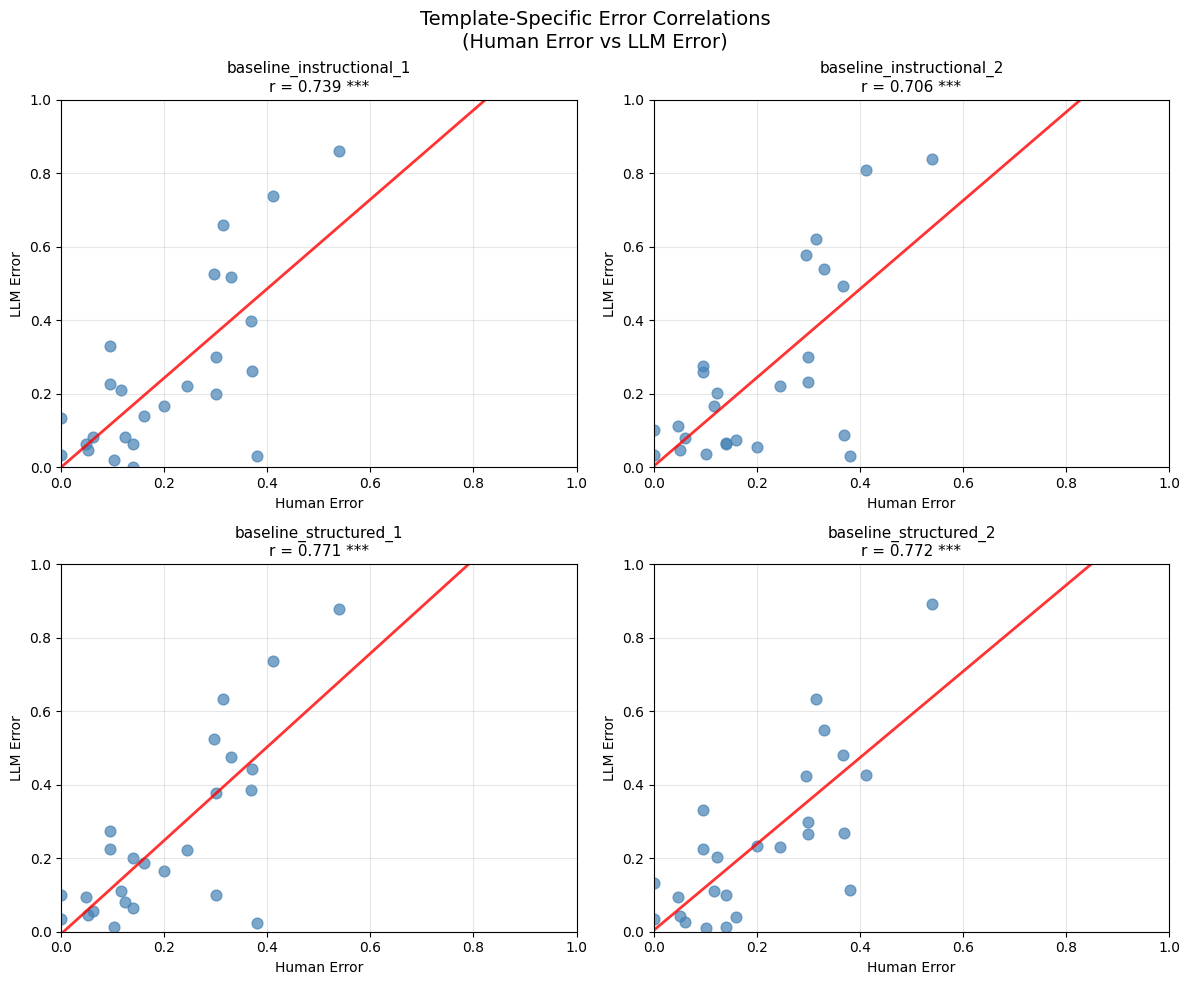

Template Analysis Summary with Statistical Significance:


,Template,Human_MAE,LLM_MAE,Error_Correlation,Error_P_Value,Error_Significance,Direction_Correlation,Direction_P_Value,Direction_Significance
0,baseline_instructional_1,0.2074,0.2524,0.7387,0.0000,***,0.8560,0.0,***
1,baseline_instructional_2,0.2074,0.2528,0.7056,0.0001,***,0.8241,0.0,***
2,baseline_structured_1,0.2074,0.2584,0.7714,0.0000,***,0.8672,0.0,***
3,baseline_structured_2,0.2074,0.2475,0.7718,0.0000,***,0.8230,0.0,***



Significance levels: *** p < 0.001, ** p < 0.01, * p < 0.05, ns = not significant

Best template for mimicking human error patterns: baseline_structured_2
Error correlation: r = 0.772, p = 0.000 ***

Sample size: n = 25 questions
With n = 25, correlations above r = 0.396 are significant at p < 0.05


In [ ]:
# Cell 12: Template-Specific Error Analysis with P-Values
print("Analysis 4: Template-Specific Error Analysis")
print("Following the 6-step methodology for each prompt template")
print("=" * 60)
print()

template_results = []

# Clean 4-panel visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, template in enumerate(averaged_table['Prompt_Template'].unique()):
    template_data = averaged_table[averaged_table['Prompt_Template'] == template].copy()

    print(f"Template: {template}")
    print("-" * 40)

    # Create 25-length vectors
    norway_vector = template_data['Norway_Rescaled'].values
    llm_vector = template_data['LLM_Rescaled'].values
    actual_vector = template_data['Actual_Rescaled'].values

    print(f"Created 25-length vectors (Length: {len(norway_vector)})")

    # Compute errors
    human_errors = np.abs(norway_vector - actual_vector)
    llm_errors = np.abs(llm_vector - actual_vector)

    # Calculate statistics with p-values
    human_mae = np.mean(human_errors)
    llm_mae = np.mean(llm_errors)
    error_correlation, error_pvalue = pearsonr(human_errors, llm_errors)

    # Direction correlation with p-value
    human_signed = norway_vector - actual_vector
    llm_signed = llm_vector - actual_vector
    direction_correlation, direction_pvalue = pearsonr(human_signed, llm_signed)

    # Statistical significance
    error_sig = "***" if error_pvalue < 0.001 else "**" if error_pvalue < 0.01 else "*" if error_pvalue < 0.05 else "ns"
    direction_sig = "***" if direction_pvalue < 0.001 else "**" if direction_pvalue < 0.01 else "*" if direction_pvalue < 0.05 else "ns"

    print(f"Human MAE: {human_mae:.3f}, LLM MAE: {llm_mae:.3f}")
    print(f"Error correlation: r = {error_correlation:.3f}, p = {error_pvalue:.3f} {error_sig}")
    print(f"Direction correlation: r = {direction_correlation:.3f}, p = {direction_pvalue:.3f} {direction_sig}")
    print()

    # Store results
    template_results.append({
        'Template': template,
        'Human_MAE': human_mae,
        'LLM_MAE': llm_mae,
        'Error_Correlation': error_correlation,
        'Error_P_Value': error_pvalue,
        'Error_Significance': error_sig,
        'Direction_Correlation': direction_correlation,
        'Direction_P_Value': direction_pvalue,
        'Direction_Significance': direction_sig
    })

    # Clean visualization
    axes[i].scatter(human_errors, llm_errors, alpha=0.7, s=60, color='steelblue')
    axes[i].set_xlabel('Human Error', fontsize=10)
    axes[i].set_ylabel('LLM Error', fontsize=10)
    axes[i].set_title(f'{template}\nr = {error_correlation:.3f} {error_sig}', fontsize=11)
    axes[i].grid(True, alpha=0.3)
    axes[i].set_xlim(0, 1)
    axes[i].set_ylim(0, 1)

    # Add trend line
    if not np.isnan(error_correlation):
        z = np.polyfit(human_errors, llm_errors, 1)
        p = np.poly1d(z)
        x_trend = np.linspace(0, max(human_errors.max(), llm_errors.max()), 100)
        axes[i].plot(x_trend, p(x_trend), "r-", alpha=0.8, linewidth=2)

plt.suptitle('Template-Specific Error Correlations\n(Human Error vs LLM Error)', fontsize=14)
plt.tight_layout()
plt.show()

# Results table with p-values
results_df = pd.DataFrame(template_results)
print("Template Analysis Summary with Statistical Significance:")
pd.set_option('display.max_rows', None)
display(results_df.round(4))
pd.reset_option('display.max_rows')

print("\nSignificance levels: *** p < 0.001, ** p < 0.01, * p < 0.05, ns = not significant")

best_template = results_df.loc[results_df['Error_Correlation'].idxmax(), 'Template']
best_correlation = results_df.loc[results_df['Error_Correlation'].idxmax(), 'Error_Correlation']
best_pvalue = results_df.loc[results_df['Error_Correlation'].idxmax(), 'Error_P_Value']
best_sig = results_df.loc[results_df['Error_Correlation'].idxmax(), 'Error_Significance']

print(f"\nBest template for mimicking human error patterns: {best_template}")
print(f"Error correlation: r = {best_correlation:.3f}, p = {best_pvalue:.3f} {best_sig}")

# Sample size reference
print(f"\nSample size: n = {len(norway_vector)} questions")
print(f"With n = 25, correlations above r = 0.396 are significant at p < 0.05")

## Cross-Template Robustness Analysis

Analysis 5: Cross-Template Robustness Analysis
Averaging LLM responses across all 4 prompt templates for final conclusion

Cross-template averaging complete: 25 questions

Final 25-length vectors created
Norway range: [0.270, 0.830]
LLM range: [0.131, 0.928]
Actual range: [0.060, 0.881]

FINAL RESULTS WITH STATISTICAL SIGNIFICANCE:
Human MAE: 0.207
LLM MAE: 0.244
Error Correlation: r = 0.769, p = 0.000 ***
Direction Correlation: r = 0.857, p = 0.000 ***

STATISTICAL INTERPRETATION:
Error correlation is HIGHLY SIGNIFICANT (p < 0.001)
Effect size: LARGE (r² = 0.591)
Variance explained: 59.1%



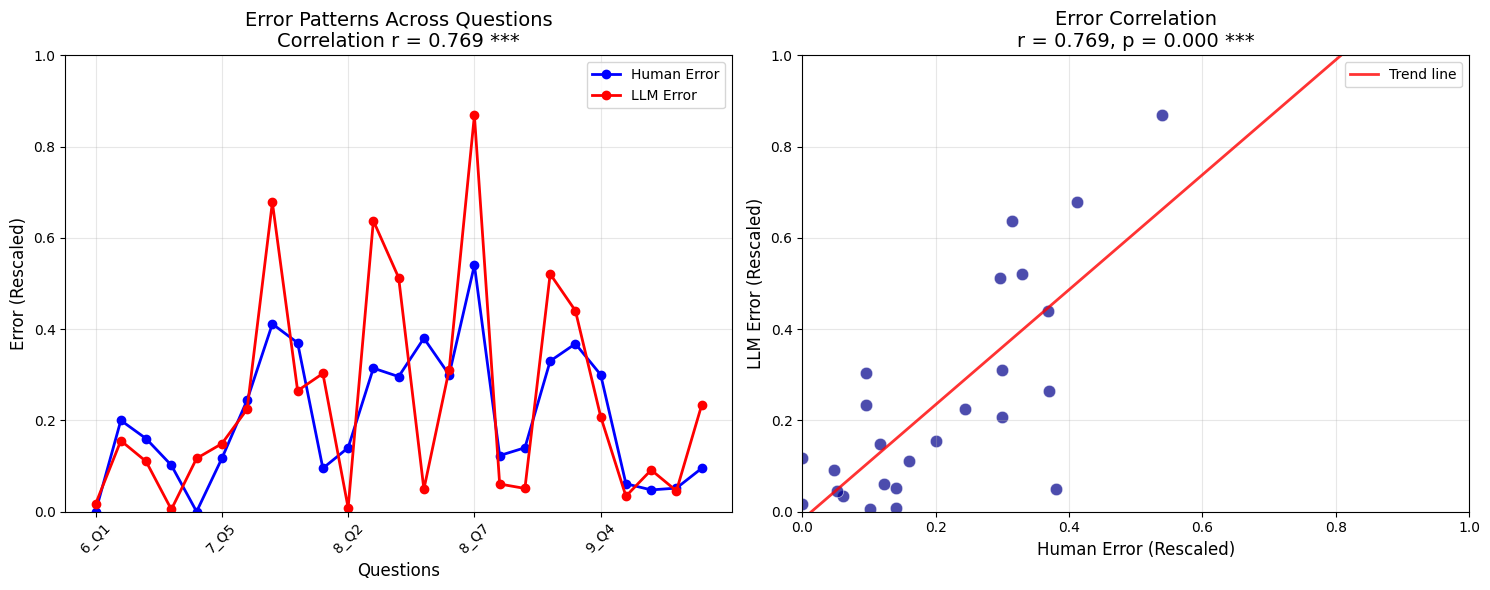


SUMMARY TABLE FOR PUBLICATION:


,Metric,Value,Significance
0,Human MAE,0.2074,
1,LLM MAE,0.2438,
2,Error Correlation,0.7687,***
3,Error P-Value,0.0000,***
4,Direction Correlation,0.8572,***
5,Direction P-Value,0.0000,***
6,Effect Size (r²),0.5908,LARGE
7,Sample Size,25.0000,



Visualization shows correlation between human and LLM error patterns across all 25 questions.
Left plot: Question-by-question error comparison
Right plot: Error correlation scatter plot
Significance levels: *** p < 0.001, ** p < 0.01, * p < 0.05, ns = not significant


In [ ]:
# Cell 13: Cross-Template Robustness Analysis with P-Values
print("Analysis 5: Cross-Template Robustness Analysis")
print("Averaging LLM responses across all 4 prompt templates for final conclusion")
print("=" * 70)
print()

# Average across templates
cross_template = averaged_table.groupby('Question_ID').agg({
    'LLM_Rescaled': 'mean',
    'Norway_Rescaled': 'first',
    'Actual_Rescaled': 'first'
}).reset_index()

print(f"Cross-template averaging complete: {len(cross_template)} questions")
print()

# Create final vectors
final_norway_vector = cross_template['Norway_Rescaled'].values
final_llm_vector = cross_template['LLM_Rescaled'].values
final_actual_vector = cross_template['Actual_Rescaled'].values

print(f"Final 25-length vectors created")
print(f"Norway range: [{final_norway_vector.min():.3f}, {final_norway_vector.max():.3f}]")
print(f"LLM range: [{final_llm_vector.min():.3f}, {final_llm_vector.max():.3f}]")
print(f"Actual range: [{final_actual_vector.min():.3f}, {final_actual_vector.max():.3f}]")
print()

# Final analysis with p-values
final_human_errors = np.abs(final_norway_vector - final_actual_vector)
final_llm_errors = np.abs(final_llm_vector - final_actual_vector)

final_human_mae = np.mean(final_human_errors)
final_llm_mae = np.mean(final_llm_errors)
final_error_correlation, final_error_pvalue = pearsonr(final_human_errors, final_llm_errors)

final_human_signed = final_norway_vector - final_actual_vector
final_llm_signed = final_llm_vector - final_actual_vector
final_direction_correlation, final_direction_pvalue = pearsonr(final_human_signed, final_llm_signed)

# Statistical significance
final_error_sig = "***" if final_error_pvalue < 0.001 else "**" if final_error_pvalue < 0.01 else "*" if final_error_pvalue < 0.05 else "ns"
final_direction_sig = "***" if final_direction_pvalue < 0.001 else "**" if final_direction_pvalue < 0.01 else "*" if final_direction_pvalue < 0.05 else "ns"

print("FINAL RESULTS WITH STATISTICAL SIGNIFICANCE:")
print(f"Human MAE: {final_human_mae:.3f}")
print(f"LLM MAE: {final_llm_mae:.3f}")
print(f"Error Correlation: r = {final_error_correlation:.3f}, p = {final_error_pvalue:.3f} {final_error_sig}")
print(f"Direction Correlation: r = {final_direction_correlation:.3f}, p = {final_direction_pvalue:.3f} {final_direction_sig}")
print()

# Statistical interpretation
print("STATISTICAL INTERPRETATION:")
if final_error_pvalue < 0.001:
    print("Error correlation is HIGHLY SIGNIFICANT (p < 0.001)")
elif final_error_pvalue < 0.01:
    print("Error correlation is VERY SIGNIFICANT (p < 0.01)")
elif final_error_pvalue < 0.05:
    print("Error correlation is SIGNIFICANT (p < 0.05)")
else:
    print("Error correlation is NOT SIGNIFICANT (p ≥ 0.05)")

# Effect size
r_squared = final_error_correlation ** 2
effect_size = "LARGE" if r_squared >= 0.25 else "MEDIUM" if r_squared >= 0.09 else "SMALL" if r_squared >= 0.01 else "NEGLIGIBLE"
print(f"Effect size: {effect_size} (r² = {r_squared:.3f})")
print(f"Variance explained: {r_squared*100:.1f}%")
print()

# Publication-quality visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Left plot: Question-level error comparison
questions = cross_template['Question_ID']
x_pos = np.arange(len(questions))

ax1.plot(x_pos, final_human_errors, 'o-', color='blue', label='Human Error', linewidth=2, markersize=6)
ax1.plot(x_pos, final_llm_errors, 'o-', color='red', label='LLM Error', linewidth=2, markersize=6)
ax1.set_xlabel('Questions', fontsize=12)
ax1.set_ylabel('Error (Rescaled)', fontsize=12)
ax1.set_title(f'Error Patterns Across Questions\nCorrelation r = {final_error_correlation:.3f} {final_error_sig}', fontsize=14)
ax1.set_xticks(x_pos[::5])
ax1.set_xticklabels([q.replace('S5E', '') for q in questions[::5]], rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1)

# Right plot: Error correlation scatter
ax2.scatter(final_human_errors, final_llm_errors, alpha=0.7, s=80, color='darkblue', edgecolors='white', linewidth=0.5)
ax2.set_xlabel('Human Error (Rescaled)', fontsize=12)
ax2.set_ylabel('LLM Error (Rescaled)', fontsize=12)
ax2.set_title(f'Error Correlation\nr = {final_error_correlation:.3f}, p = {final_error_pvalue:.3f} {final_error_sig}', fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)

# Add trend line
if not np.isnan(final_error_correlation):
    z = np.polyfit(final_human_errors, final_llm_errors, 1)
    p = np.poly1d(z)
    x_trend = np.linspace(0, max(final_human_errors.max(), final_llm_errors.max()), 100)
    ax2.plot(x_trend, p(x_trend), "r-", alpha=0.8, linewidth=2,
             label=f'Trend line')
    ax2.legend()

plt.tight_layout()
plt.show()

# Summary table for publication
summary_stats = pd.DataFrame({
    'Metric': ['Human MAE', 'LLM MAE', 'Error Correlation', 'Error P-Value',
               'Direction Correlation', 'Direction P-Value', 'Effect Size (r²)', 'Sample Size'],
    'Value': [final_human_mae, final_llm_mae, final_error_correlation, final_error_pvalue,
              final_direction_correlation, final_direction_pvalue, r_squared, len(final_norway_vector)],
    'Significance': ['', '', final_error_sig, final_error_sig,
                    final_direction_sig, final_direction_sig, effect_size, '']
})

print("\nSUMMARY TABLE FOR PUBLICATION:")
pd.set_option('display.max_rows', None)
display(summary_stats.round(4))
pd.reset_option('display.max_rows')

print(f"\nVisualization shows correlation between human and LLM error patterns across all 25 questions.")
print(f"Left plot: Question-by-question error comparison")
print(f"Right plot: Error correlation scatter plot")
print(f"Significance levels: *** p < 0.001, ** p < 0.01, * p < 0.05, ns = not significant")